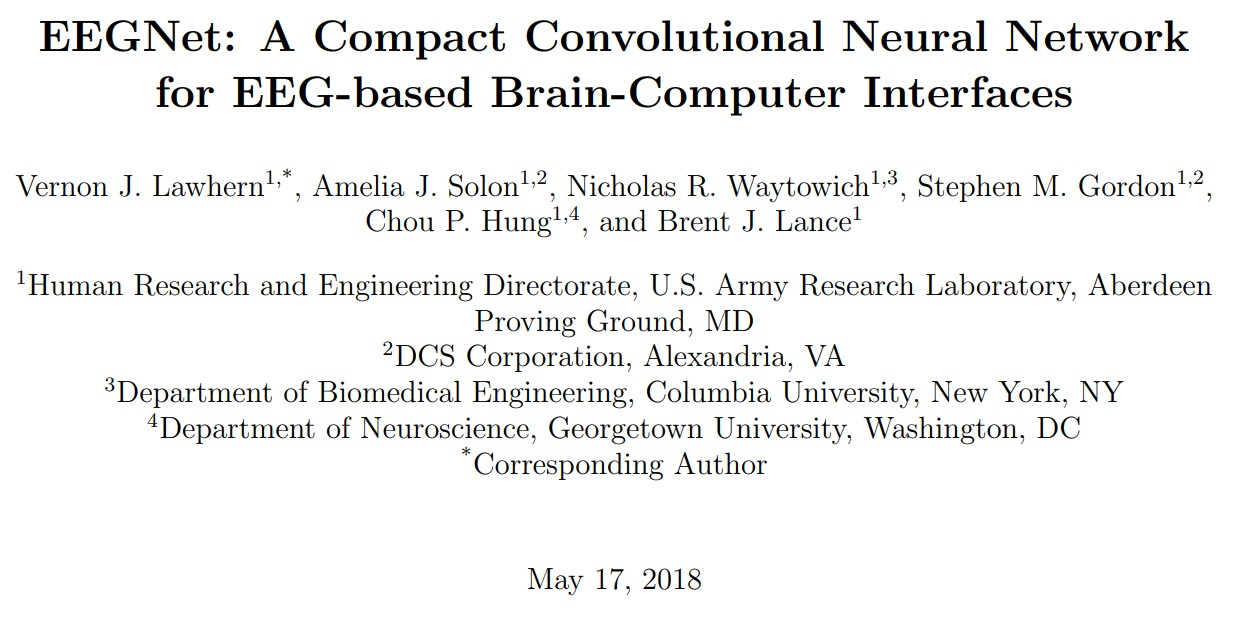

DOI : 10.1088/1741-2552/aace8c

------------------------------

# architecture

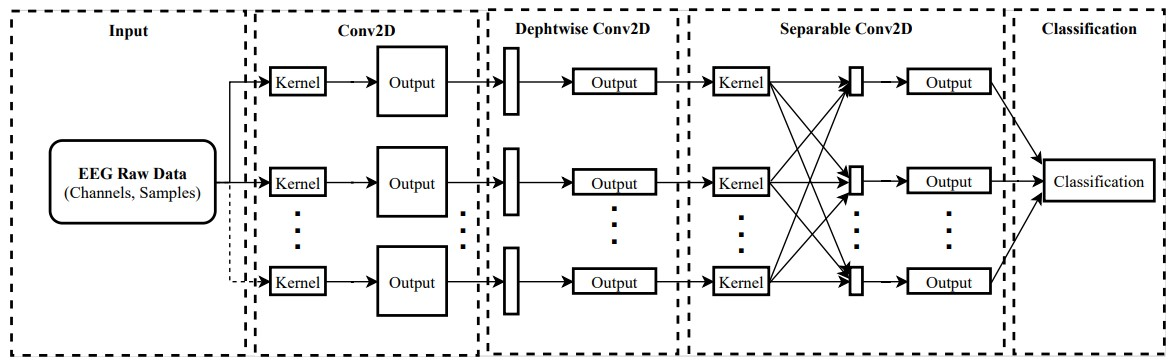

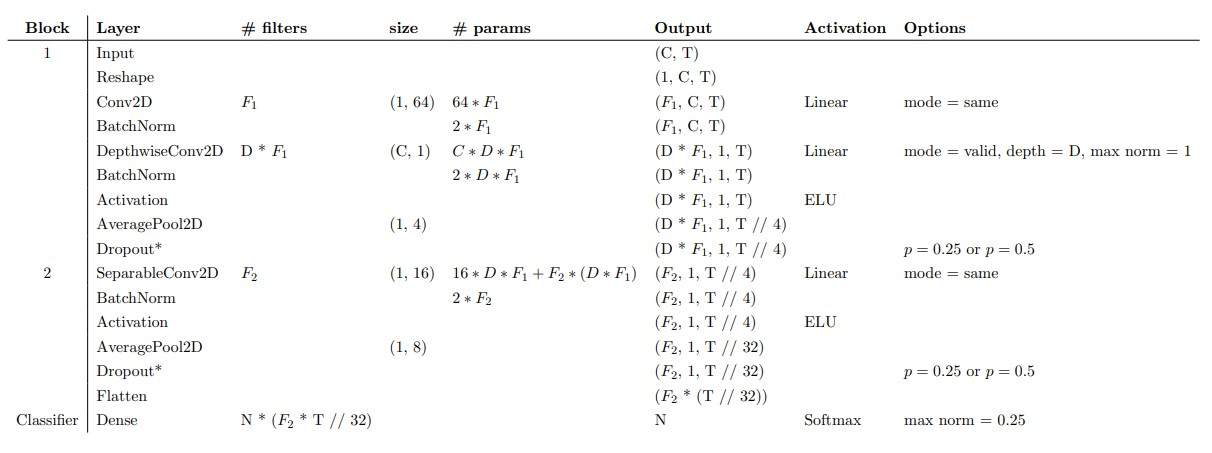

------------------------------

# code

## import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics import Accuracy

## set model specifications

In [2]:
fs= 200                  #sampling frequency
channel= 22              #number of electrode
num_input= 1             #number of channel picture (for EEG signal is always : 1)
num_class= 5             #number of classes 
signal_length = 200      #number of sample in each tarial

F1= 8                    #number of temporal filters
D= 3                     #depth multiplier (number of spatial filters)
F2= D*F1                 #number of pointwise filters

In [3]:
device= 'cpu'
kernel_size_1= (1,round(fs/2)) 
kernel_size_2= (channel, 1)
kernel_size_3= (1, round(fs/8))
kernel_size_4= (1, 1)

kernel_avgpool_1= (1,4)
kernel_avgpool_2= (1,8)
dropout_rate= 0.2

ks0= int(round((kernel_size_1[0]-1)/2))
ks1= int(round((kernel_size_1[1]-1)/2))
kernel_padding_1= (ks0, ks1-1)
ks0= int(round((kernel_size_3[0]-1)/2))
ks1= int(round((kernel_size_3[1]-1)/2))
kernel_padding_3= (ks0, ks1)

## design model

In [4]:
class EEGNet(nn.Module): 
    def __init__(self):
        super().__init__()
        # layer 1
        self.conv2d = nn.Conv2d(num_input, F1, kernel_size_1, padding=kernel_padding_1)
        self.Batch_normalization_1 = nn.BatchNorm2d(F1)
        # layer 2
        self.Depthwise_conv2D = nn.Conv2d(F1, D*F1, kernel_size_2, groups= F1)
        self.Batch_normalization_2 = nn.BatchNorm2d(D*F1)
        self.Elu = nn.ELU()
        self.Average_pooling2D_1 = nn.AvgPool2d(kernel_avgpool_1)
        self.Dropout = nn.Dropout2d(dropout_rate)
        # layer 3
        self.Separable_conv2D_depth = nn.Conv2d( D*F1, D*F1, kernel_size_3,
                                                padding=kernel_padding_3, groups= D*F1)
        self.Separable_conv2D_point = nn.Conv2d(D*F1, F2, kernel_size_4)
        self.Batch_normalization_3 = nn.BatchNorm2d(F2)
        self.Average_pooling2D_2 = nn.AvgPool2d(kernel_avgpool_2)
        # layer 4
        self.Flatten = nn.Flatten()
        self.Dense = nn.Linear(F2*round(signal_length/32), num_class)
        self.Softmax = nn.Softmax(dim= 1)
        
        
    def forward(self, x):
        # layer 1
        y = self.Batch_normalization_1(self.conv2d(x)) #.relu()
        # layer 2
        y = self.Batch_normalization_2(self.Depthwise_conv2D(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_1(y))
        # layer 3
        y = self.Separable_conv2D_depth(y)
        y = self.Batch_normalization_3(self.Separable_conv2D_point(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_2(y))
        # layer 4
        y = self.Flatten(y)
        y = self.Dense(y)
        y = self.Softmax(y)
        
        return y
    
model = EEGNet()

## create random data

In [5]:
signal= torch.randn(1280,1,22,200)
label= torch.randint(2, (1280,))

train_batch_size= 256

dataset= TensorDataset(signal, label)

data_loader= DataLoader(dataset, 
                         batch_size= train_batch_size, 
                         shuffle=True)

print("train batch size:",data_loader.batch_size,
     ", num of batch:", len(data_loader))

train batch size: 256 , num of batch: 5


## train function

In [6]:
def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes= num_class).to(device)
    
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
        
    return model, loss_train.avg, acc_train.compute().item()

## utils

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## training

In [8]:
num_epochs = 101
loss_fn= nn.CrossEntropyLoss().to(device)
optimizer= optim.NAdam(model.parameters(), lr= 0.01)

loss_train_hist = []
acc_train_hist = []

for epoch in range(num_epochs):
    model, loss_train, acc_train = train_one_epoch(model, 
                                                 data_loader, 
                                                 loss_fn, 
                                                 optimizer)
  
    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)

    if (epoch%10== 5)or(epoch%10== 0): 
        print(f'epoch {epoch}:')
        print(f' Loss= {loss_train:.4}, Accuracy= {int(acc_train*100)}% \n')

epoch 0:
 Loss= 1.483, Accuracy= 43% 

epoch 5:
 Loss= 1.289, Accuracy= 60% 

epoch 10:
 Loss= 1.217, Accuracy= 69% 

epoch 15:
 Loss= 1.149, Accuracy= 75% 

epoch 20:
 Loss= 1.078, Accuracy= 83% 

epoch 25:
 Loss= 1.042, Accuracy= 87% 

epoch 30:
 Loss= 1.009, Accuracy= 90% 

epoch 35:
 Loss= 1.02, Accuracy= 88% 

epoch 40:
 Loss= 0.9845, Accuracy= 92% 

epoch 45:
 Loss= 0.9825, Accuracy= 92% 

epoch 50:
 Loss= 0.99, Accuracy= 91% 

epoch 55:
 Loss= 0.969, Accuracy= 93% 

epoch 60:
 Loss= 0.9712, Accuracy= 93% 

epoch 65:
 Loss= 0.9495, Accuracy= 96% 

epoch 70:
 Loss= 0.96, Accuracy= 94% 

epoch 75:
 Loss= 0.9622, Accuracy= 94% 

epoch 80:
 Loss= 0.9565, Accuracy= 95% 

epoch 85:
 Loss= 0.9472, Accuracy= 96% 

epoch 90:
 Loss= 0.9413, Accuracy= 96% 

epoch 95:
 Loss= 0.9481, Accuracy= 96% 

epoch 100:
 Loss= 0.9449, Accuracy= 96% 



## learning curve

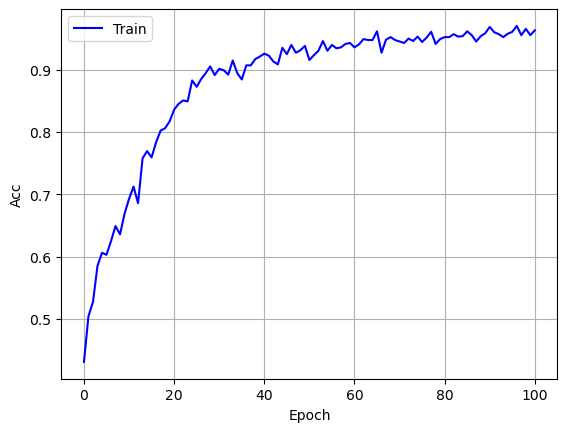

In [9]:
plt.plot(range(num_epochs), acc_train_hist, 'b-', label='Train')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()